# MonteCarlo

First vist montecarlo

In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

In [2]:
class First_Vist_MonteCarlo:
    def __init__(self, config):
        self.n_actions = config.n_actions
        self.epsilon = config.epsilon
        self.gamma = config.gamma
        self.Q_table = defaultdict(lambda: np.zeros(config.n_actions))
        self.return_sum = defaultdict(float)
        self.return_cnt = defaultdict(float)
    
    def sample_action(self, state):
        state = str(state)
        if state in self.Q_table.keys():
            if np.random.rand() < self.epsilon:
                return np.random.randint(0, self.n_actions)
            else:
                return np.argmax(self.Q_table[state]) 
        else:
            return np.random.randint(0, self.n_actions)
    
    def predict_action(self, state):
        state = str(state)
        if state in self.Q_table.keys():
            return np.argmax(self.Q_table[state])
        else:
            return np.random.randint(0, self.n_actions)
    
    def update(self, one_ep_transition):
        sa_in_episode = set([(str(x[0]), x[1]) for x in one_ep_transition])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # 可以空间换时间, 可以从前往后枚举 one_ep_transition, 然后 book掉没用的
            first_occurence_index = next(i for i, x in enumerate(one_ep_transition) if str(x[0]) == state and x[1] == action)
            G = sum(x[2] * (self.gamma ** i) for i, x in enumerate(one_ep_transition[first_occurence_index:])) # 时间复杂度瓶颈在这里, 但是也可以优化
            self.return_sum[sa_pair] += G
            self.return_cnt[sa_pair] += 1 # 因为 set的原因, 在这个地方每一个 epoch只会更新一次 (state, action)
            self.Q_table[state][action] = self.return_sum[sa_pair] / self.return_cnt[sa_pair] # 也可以用增量式更新

In [3]:
def train(env, agent, config, mode='train'):
    print("---" * 45)
    print(f'环境 : {config.env_name}, 算法: {config.algorithm}, 设备: {config.device}')
    rewards = []
    epochs = config.train_epochs if mode == 'train' else config.test_epochs
    tqdm_iterator = tqdm(range(epochs))
    for i in tqdm_iterator:
        tqdm_iterator.set_description(f'{mode}[{i + 1}/{epochs}] (Epsilon: {agent.epsilon:.3f})')
        epoch_reward = 0
        epoch_step = 0
        one_epoch_transition = []
        state = env.reset()
        while True:
            epoch_step += 1
            action = agent.sample_action(state) if mode == 'train' else agent.predict_action(state)
            next_state, reward, terminated, _ = env.step(action)
            one_epoch_transition.append((state, action, reward))
            state = next_state
            epoch_reward += reward
            if terminated or epoch_step > config.max_step:
                break
        if mode == 'train':
            agent.update(one_epoch_transition)
        rewards.append(epoch_reward)
    print('-'*60 + '完成训练' + '-'*60)
    return rewards

### 定义环境

In [4]:
from envs.racetrack import RacetrackEnv

class Configuration:
    def __init__(self):
        self.env_name = 'Racetrack-v0'
        self.algorithm ='FirstVistMC'
        self.train_epochs = 500
        self.test_epochs = 20
        self.max_step = 300
        self.epsilon = 0.1
        self.gamma = 0.9
        self.lr = 0.5
        self.device = 'cpu' # 没用 torch...

def env_agent_config(config):
    env = RacetrackEnv()
    setattr(config, 'n_states', env.observation_space.shape[0])
    setattr(config, 'n_actions', env.action_space.n)
    agent = First_Vist_MonteCarlo(config)
    return env, agent

### 可视化工具

In [5]:
import matplotlib.pyplot as plt
import d2l.torch as d2l
d2l.use_svg_display()

def smooth(data, weight=0.9):  
    '''用于平滑曲线
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

### 开始训练

---------------------------------------------------------------------------------------------------------------------------------------
环境 : Racetrack-v0, 算法: FirstVistMC, 设备: cpu


train[500/500] (Epsilon: 0.100): 100%|██████████| 500/500 [00:17<00:00, 28.59it/s] 


------------------------------------------------------------完成训练------------------------------------------------------------


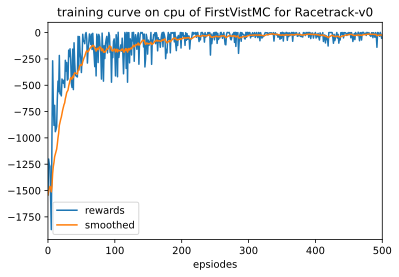

In [6]:
config = Configuration()
env, agent = env_agent_config(config)
result = train(env, agent, config)
plot_rewards(result, title=f"training curve on {config.device} of {config.algorithm} for {config.env_name}")  

---------------------------------------------------------------------------------------------------------------------------------------
环境 : Racetrack-v0, 算法: FirstVistMC, 设备: cpu


test[20/20] (Epsilon: 0.100): 100%|██████████| 20/20 [00:00<00:00, 715.90it/s]

------------------------------------------------------------完成训练------------------------------------------------------------


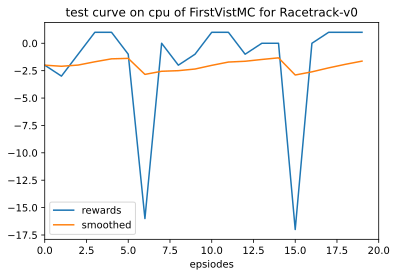

In [7]:
result = train(env, agent, config, mode='test')
plot_rewards(result, title=f"test curve on {config.device} of {config.algorithm} for {config.env_name}")  